<a href="https://colab.research.google.com/github/lee4205/Potato_Chip_Classification/blob/master/lllllllllllllllllllllllllllllllllllllllllllllllll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning into 'Potato_Chip_Classification'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 2009 (delta 78), reused 78 (delta 22), pack-reused 1823
Receiving objects: 100% (2009/2009), 154.26 MiB | 35.29 MiB/s, done.
Resolving deltas: 100% (180/180), done.


In [2]:
cd Potato_Chip_Classification

/content/Potato_Chip_Classification


In [3]:
import sys
import os
import csv
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [4]:
cwd = os.getcwd()
subprocess.run(["mkdir " + cwd + "/dataset"], shell=True)

CompletedProcess(args=['mkdir /content/Potato_Chip_Classification/dataset'], returncode=0)

In [5]:
image_width = 1280 // 10
image_height = 960 // 10
image_size = (image_width, image_height)
image_channel = 1

In [6]:
flavors = os.listdir(cwd + "/potato-chips")
with open("potato_chips.csv", 'a') as c:
    csv_input = csv.writer(c)
    pixels = []
    pixel = 0
    for x in range((image_width)*(image_height)):
        pixel += 1
        pixels.append('pixel'+ str(pixel))
    header = ["image", "flavor"]
    header.extend(pixels)
    csv_input.writerow(header)
    for flavor in flavors:
        images = os.listdir(cwd + f"/potato-chips/{flavor}")
        print("loading image from " + flavor + " ...")
        for image in images:
            rgb_image = Image.open(cwd + f"/potato-chips/{flavor}/" + image)
            grey_image = rgb_image.convert('L').resize((image_width, image_height))
            pixel_data = np.asarray(grey_image.getdata(), dtype=np.int).reshape((grey_image.size[1], grey_image.size[0]))
            pixel_data = pixel_data.flatten()
            image_data = [image, flavors.index(flavor)]
            image_data.extend(pixel_data)
            csv_input.writerow(image_data)
        subprocess.run(["cp " + cwd + "/potato-chips/" + flavor + "/*.jpg " + cwd + "/dataset"], shell=True)

loading image from consomme-punch ...
loading image from norishio-punch ...
loading image from norishio ...
loading image from shiawase-butter ...
loading image from kyusyu-shoyu ...
loading image from usushio ...
loading image from shoyu-mayo ...


In [7]:
df = pd.read_csv(cwd + "/potato_chips.csv")
train_df, validate_df = train_test_split(df, train_size=0.6, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
y = validate_df['flavor']

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


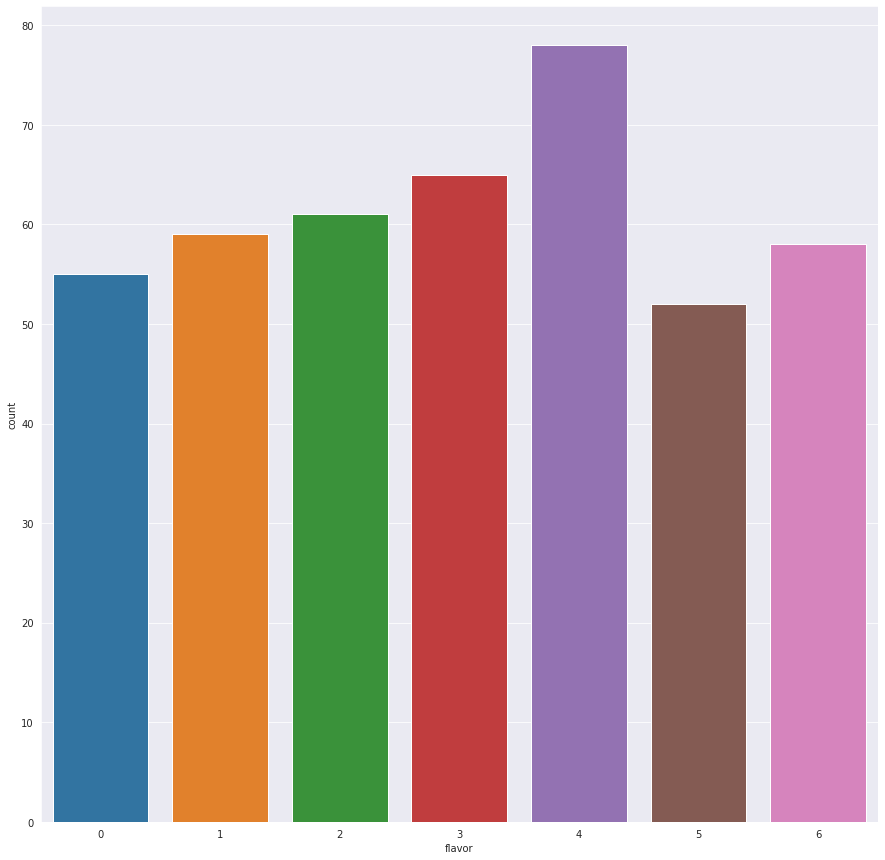

In [8]:
# デバッグ用
# train_df
# validate_df
# test_df
# plt.figure(figsize = (15,15))
# sns.set_style("darkgrid")
# sns.countplot(train_df['flavor'])
# sns.countplot(validate_df['flavor'])
# sns.countplot(test_df['flavor'])

In [9]:
y_train = train_df['flavor']
y_validate = validate_df['flavor']
del train_df['image'], train_df['flavor']
del validate_df['image'], validate_df['flavor']

In [10]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_validate = label_binarizer.fit_transform(y_validate)

In [11]:
x_train = train_df.values
x_validate = validate_df.values

In [12]:
x_train = x_train / 255
x_validate = x_validate / 255

In [13]:
x_train = x_train.reshape(-1,image_height,image_width,1)
x_validate = x_validate.reshape(-1,image_height,image_width,1)

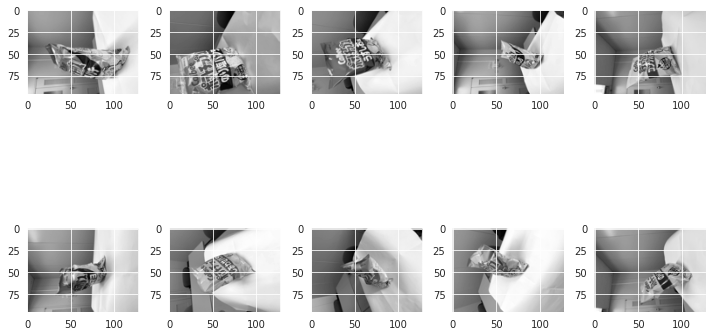

In [14]:
# デバッグ用
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(image_height,image_width) , cmap = "gray")
        k += 1
    plt.tight_layout()    

In [15]:
datagen = ImageDataGenerator(featurewise_center=False, # set input mean to 0 over the dataset
                             samplewise_center=False, # set each sample mean to 0
                             featurewise_std_normalization=False, # divide inputs by std of the dataset
                             samplewise_std_normalization=False, # divide each input by its std
                             zca_whitening=False, # apply ZCA whitening
                             rotation_range=10, # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range = 0.1, # Randomly zoom image 
                             width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
                             horizontal_flip=False, # randomly flip images
                             vertical_flip=False) # randomly flip images
datagen.fit(x_train)

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience =2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [17]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (image_width,image_height,image_channel)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 7 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 96, 75)       750       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 96, 75)       300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 48, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 48, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 64, 48, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 48, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 24, 50)        0

In [18]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 5),
                    epochs = 200,
                    validation_data = (x_validate, y_validate),
                    callbacks = [learning_rate_reduction])

Epoch 1/200
86/86 [==============================] - 26s 290ms/step - loss: 5.1613 - accuracy: 0.2228 - val_loss: 4.8566 - val_accuracy: 0.1259
Epoch 2/200
86/86 [==============================] - 25s 286ms/step - loss: 1.9207 - accuracy: 0.3960 - val_loss: 4.4996 - val_accuracy: 0.2238
Epoch 3/200
86/86 [==============================] - 25s 286ms/step - loss: 1.5406 - accuracy: 0.4537 - val_loss: 4.2802 - val_accuracy: 0.2168
Epoch 4/200
86/86 [==============================] - 25s 287ms/step - loss: 1.2832 - accuracy: 0.5554 - val_loss: 6.5598 - val_accuracy: 0.1958

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/200
86/86 [==============================] - 25s 289ms/step - loss: 1.2268 - accuracy: 0.5607 - val_loss: 3.2415 - val_accuracy: 0.3427
Epoch 6/200
86/86 [==============================] - 25s 288ms/step - loss: 0.8889 - accuracy: 0.7152 - val_loss: 2.4542 - val_accuracy: 0.3846
Epoch 7/200
86/86 [==============================] - 25

In [19]:
print("Accuracy of the model is - " , model.evaluate(x_validate,y_validate)[1]*100 , "%")

5/5 [==============================] - 1s 286ms/step - loss: 0.2039 - accuracy: 0.9301
Accuracy of the model is -  93.00699234008789 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  


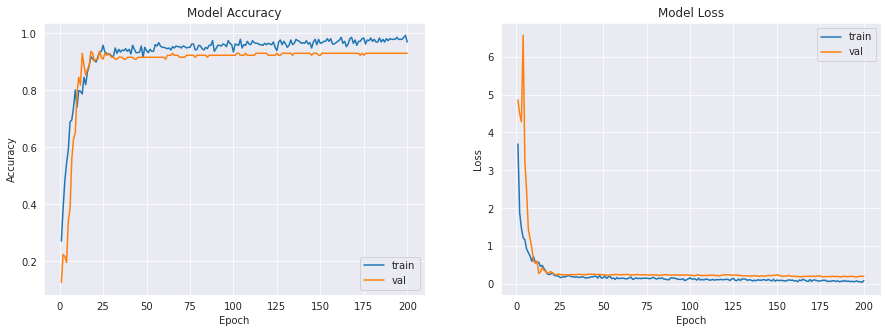

In [20]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(range(1,len(history.history["accuracy"])+1),history.history["accuracy"])
axs[0].plot(range(1,len(history.history["val_accuracy"])+1),history.history["val_accuracy"])
axs[0].set_title("Model Accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_xticks(np.arange(1,len(history.history["accuracy"])+1),len(history.history["accuracy"])/10)
axs[0].legend(["train", "val"], loc="best")
axs[1].plot(range(1,len(history.history["loss"])+1),history.history["loss"])
axs[1].plot(range(1,len(history.history["val_loss"])+1),history.history["val_loss"])
axs[1].set_title("Model Loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_xticks(np.arange(1,len(history.history["loss"])+1),len(history.history["loss"])/10)
axs[1].legend(["train", "val"], loc="best")
plt.show()

In [21]:
predictions = model.predict_classes(x_validate)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5] 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([5, 4, 0, 0, 5])

In [22]:
classes = ["Class " + str(i) for i in range(8) if i != 0]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 1       1.00      0.77      0.87        30
     Class 2       1.00      1.00      1.00        12
     Class 3       0.85      1.00      0.92        28
     Class 4       1.00      1.00      1.00        28
     Class 5       0.92      1.00      0.96        12
     Class 6       1.00      0.89      0.94        18
     Class 7       0.78      0.93      0.85        15

    accuracy                           0.93       143
   macro avg       0.94      0.94      0.93       143
weighted avg       0.94      0.93      0.93       143



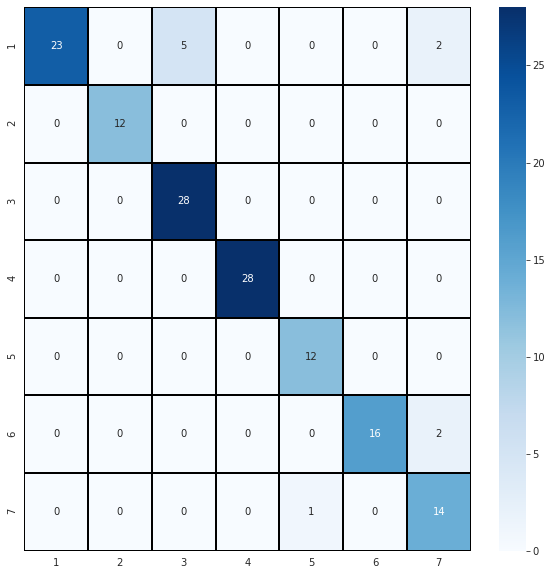

In [23]:
cm = confusion_matrix(y,predictions)
cm = pd.DataFrame(cm , index = [i for i in range(8) if i != 0] , columns = [i for i in range(8) if i != 0])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [24]:
correct = np.nonzero(predictions == y)[0]

ValueError: ignored

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_validate[c].reshape(image_height,image_width), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1